In [146]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
from scorer import ScorerInfo
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")


In [147]:
calcs = {'auROC': ScorerInfo("prroc_rocauc", "rocauc").make(),
         'auPRC': ScorerInfo("prroc_prauc", "prauc", params={"type": "integral"}).make()}

In [148]:
# model_name, version = 'MYPOP-CHS-GHTS-2', 0
# # model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
# path_to_model = '/home/nikgr/mex_models/shades_one_5/%s' % model_name
# path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
# path_to_preds = path_to_model + '/model/predictions_new_format_%s.tsv'
# path_to_conf = path_to_model + '/config.json'
# model_full_descr = 'LegNet (%s)' % (model_name)

In [149]:

# model_name, version = 'GABPA-CHS-GHTS-1', 0
# # model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
# path_to_model = '/home/nikgr/mex_models_prod/shades_one_run/%s' % model_name
# path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
# path_to_preds = path_to_model + '/model/predictions_new_format_%s.tsv'
# path_to_conf = path_to_model + '/config.json'
# model_full_descr = 'LegNet (%s)' % (model_name)

In [150]:
model_name, version = 'ZNF226-CHS-GHTS-2', 0
path_to_model = '/home/nikgr/mex_models_prod/first_run/%s' % model_name
path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
path_to_preds = path_to_model + '/model/predictions_new_format.tsv'
path_to_conf = path_to_model + '/config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [151]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/nikgr/mex_models_prod/first_run/ZNF226-CHS-GHTS-1/config.json
{'stem_ch': 40, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': False, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.0025, 'weight_decay': 0.1, 'model_dir': '/home/nikgr/mex_models_prod/first_run/ZNF226-CHS-GHTS-1', 'train_path': '/home/nikgr/MEX/DATASETS/CHS/Train/ZNF226', 'ref_genome_path': '/home/nikgr/hg38/hg38.fa', 'valid_path': '/home/nikgr/MEX/DATASETS/CHS/Test/ZNF226', 'test_path': '/home/nikgr/MEX/DATASETS/GHTS/Test/ZNF226', 'epoch_num': 10, 'device': 0, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 24, 'training': True, 'negatives': ['foreigns'], 'pwms_path': None, 'pwms_freeze': False, 'pwm_loc': None, 'model_type': 'LegNet'}


In [152]:
def get_mod_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    aug = ' & '.join(aug)
    neg = ' & '.join(conf['negatives']) + ' neg.'
    ep_n = f'{conf["epoch_num"]} ep.'
    return f'LegNet ' + ', '.join([aug, neg, ep_n])

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

mod_info = get_mod_info(model_config)
run_info = get_run_info(model_config)
print(mod_info)
print(run_info)

LegNet with rev & 25 shift aug, foreigns neg., 10 ep.
ZNF226 CHS/GHTS


In [153]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss
5,0.056662,0.519014,5,209,0.055792
6,0.055405,0.527053,6,244,0.056622
7,0.055390,0.550511,7,279,0.055227
8,0.055240,0.561111,8,314,0.054626
9,0.055236,0.561982,9,349,0.054857


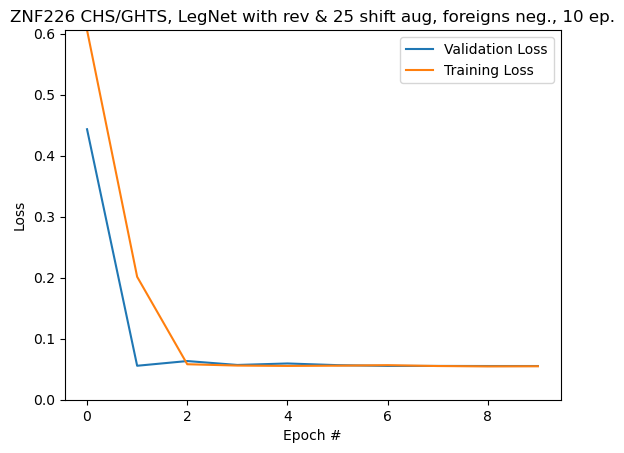

In [154]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


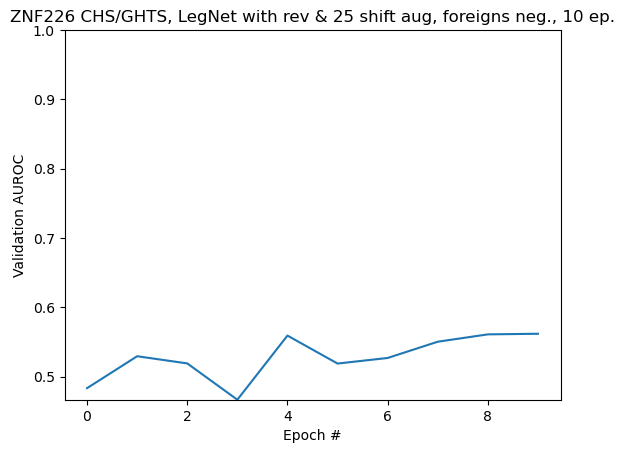

In [155]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
# ax.set_ylim(0.8, 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [156]:
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}
def process_preds_df(path, split, old=False):
    preds_df = pd.read_csv(path % split if not old else path, sep='\t')
    preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
    return preds_df

In [157]:
def plot_roc(preds_df, split):
    ax = plt.axes()
    ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.title(f'ROC on {run_info}, {mod_info} [{split}]')
        
    for pred in preds:
        fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
        auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
        auc_correct = calcs['auROC'].score(preds_df[pred], preds_df['class_'])
        print(pred, auc_correct)

        plt.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
    plt.show()
    
def plot_pr(preds_df, split):
    ax = plt.axes()
    # ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.title(f'PR on {run_info}, {mod_info} [{split}]')
        
    for pred in preds:
        precision, recall, _ = metrics.precision_recall_curve(preds_df['class_'], preds_df[pred])
        pr = metrics.average_precision_score(preds_df['class_'], preds_df[pred])
        pr_correct = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
        print(pred, pr_correct)

        plt.plot(recall, precision, label=f'{preds_names[pred]}, PR = {pr:.3}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower right')
    plt.show()

In [158]:
try:
    for split in ('valid', 'test'):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  
        

----------------------------------------valid-----------------------------------------


-----------------------------------------test-----------------------------------------
forw_pred 0.544310700827542
avg_pred 0.5584802042026653


rev_pred 0.5446286843303927


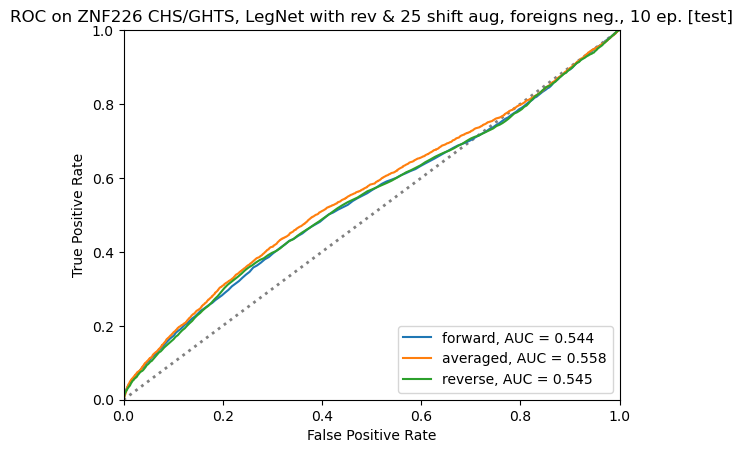

forw_pred 0.014809982952912241
avg_pred 0.01491951379702707
rev_pred 0.014058836287364606


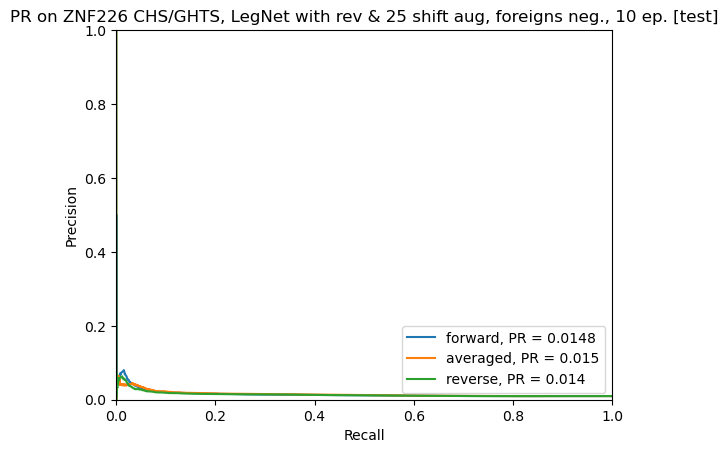

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


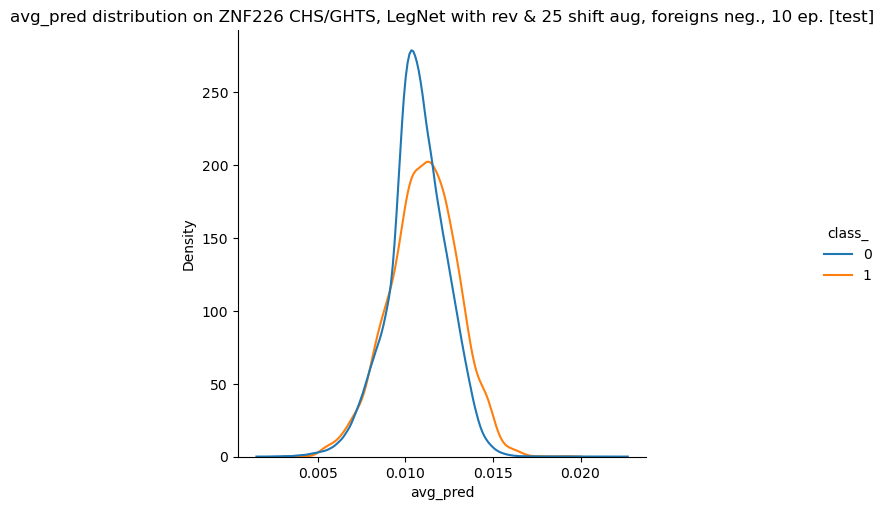

In [159]:
try:
    for split in ('test',):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split, old=True)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  